In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
from zipfile import ZipFile
import json
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import load_img, image_dataset_from_directory

C:\Users\Christina\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Christina\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\Christina\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Christina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------
# Read train and test sets

In [2]:
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

with open("classlabels.txt") as infile:
    labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


-----------
# Select labels

In [3]:
labels_to_keep = [0, 6, 4, 18] # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])

finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 4 classes are: limit30, nouturn, noleft, nostopping


----------------
# Plot example data

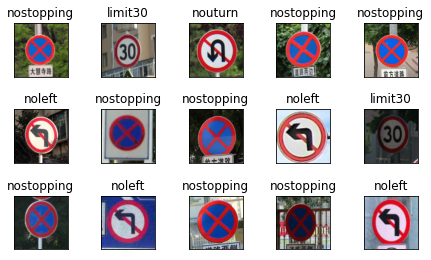

In [4]:
fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    img = array_to_img(x_train[i])
    plt.imshow(img)
    plt.title(finallabels[y_train[i]])
    plt.xticks([])
    plt.yticks([])
plt.savefig("visualizations/example-data.png",bbox_inches='tight')

------------------------
# Explore and pre-process the data

In [5]:
# check the number of samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

564 train samples
402 test samples


In [6]:
type(x_train)

numpy.ndarray

In [7]:
x_train.shape # RGB images have a depth of 3

(564, 128, 128, 3)

In [8]:
x_test.shape

(402, 128, 128, 3)

In [9]:
x_train.min()

0.0

In [10]:
x_train.max()

255.0

In [11]:
# Normalize pixel values to be between 0 and 1 by dividing by 255. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
x_train.min()

0.0

In [13]:
x_train.max()

1.0

# Model

In [14]:
def create_CNN(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(10))
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [15]:
input_shape = x_train.shape[1:4]
num_classes = 4

model = create_CNN(input_shape, num_classes)
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [17]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test)

Epoch 1/10
18/18 [==============================] - 6s 327ms/step - loss: 1.0703 - accuracy: 0.5727 - val_loss: 0.9207 - val_accuracy: 0.5672
Epoch 2/10
18/18 [==============================] - 6s 321ms/step - loss: 0.6918 - accuracy: 0.7305 - val_loss: 0.7250 - val_accuracy: 0.7413
Epoch 3/10
18/18 [==============================] - 8s 426ms/step - loss: 0.4805 - accuracy: 0.8121 - val_loss: 0.6275 - val_accuracy: 0.7313
Epoch 4/10
18/18 [==============================] - 7s 409ms/step - loss: 0.4132 - accuracy: 0.8387 - val_loss: 0.6271 - val_accuracy: 0.7313
Epoch 5/10
18/18 [==============================] - 7s 414ms/step - loss: 0.3644 - accuracy: 0.8546 - val_loss: 0.6066 - val_accuracy: 0.7413
Epoch 6/10
18/18 [==============================] - 7s 406ms/step - loss: 0.3199 - accuracy: 0.8830 - val_loss: 0.5751 - val_accuracy: 0.7662
Epoch 7/10
18/18 [==============================] - 7s 411ms/step - loss: 0.2906 - accuracy: 0.8901 - val_loss: 0.6205 - val_accuracy: 0.7662
Epoch 

13/13 - 1s - loss: 0.5903 - accuracy: 0.7711 - 1s/epoch - 91ms/step


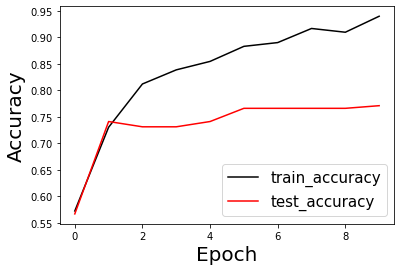

In [18]:
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

13/13 - 1s - loss: 0.5903 - accuracy: 0.7711 - 1s/epoch - 84ms/step


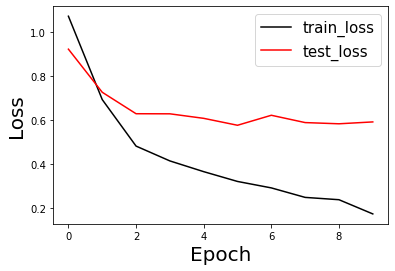

In [19]:
plt.plot(history.history['loss'], label='train_loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'test_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='upper right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')

In [20]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the model is:")
print(test_acc)

13/13 - 1s - loss: 0.5903 - accuracy: 0.7711 - 1s/epoch - 81ms/step
The accuracy of the model is:
0.7711442708969116
